## Cell Dynamics Classification - impute using rolling mean for missing data

Group 10.  August 8, 2024

This notebook collects the features engineered from the Cell Dynamics data provided by Nicolas Malagon

Contributors: Chris, Vasav, Wasif, Tim

#### Notes
- This notebook requires the preprocessed dataset with imputed values, **multi_level_combined_imputed_final_movie_level.csv**
- Create the csv by running **10_Preprocess_Impute.ipynb**


## Problem Description

By employing unsupervised learning, we aim to generate clusters based on a specific cellular parameter, aiding our understanding of how tissues reduce their area. The parameters of interest are cell area and delta (the rate of change in cell size). This research can enhance our comprehension of the cell dynamics involved in the early stages of cancer.

The data contains 131 time series with between 39 and 49 time points each. The time series are extracted from three time lapse movies. They correspond to the development of 131 cells from three different fruit fly sex combs.  

Missing values represent times at which the cells were unable to be measured accurately. They are either ignored or imputed using a rolling average, with a window size of approximately half the time series.

We will use clustering techniques to investigate typical classes of cell development. This will help us to strategize different approaches toward the ultimate goal, which is to classify different spatio-temporal characteristics in the non-periodic oscillation of delta over time. 


# Load the Preprocessed data

In [6]:
# import required libraries/modules
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [17]:
combined_df_movie_level = pd.read_csv('multi_level_combined_imputed_final_movie_level.csv', header=[0, 1, 2], index_col=0)
combined_df_movie_level.columns.names = ['Movie', 'Cell', 'Trend']
display(combined_df_movie_level.head(5))

Movie            Movie 1                                                \
Cell              Cell 2           Cell 3             Cell 4             
Trend               area     delta   area    delta      area     delta   
Interval [min]                                                           
0               4.604450  0.158100  5.217 -0.21750  6.284200 -1.976200   
20              4.553060  0.098800  5.138 -0.26880  6.297367 -0.474300   
40              4.479283  0.031620  5.409  0.15800  6.303950 -0.316200   
60              4.550800  0.171267  5.632  0.15800  6.149800 -0.434775   
80              4.594563  0.135514  6.087  0.13825  6.284183 -0.063240   

Movie                                                   ...  Movie 3          \
Cell              cell 5              Cell 6            ...  Cell 53           
Trend               area     delta      area     delta  ...     area   delta   
Interval [min]                                          ...                    
0               6.778250 -0.553333  9.189250 -0.316333  ...  25.3154  0.1539   
20              7.019340 -0.039525  9.137800 -0.197750  ...  25.4693  0.6156   
40              6.982450 -0.268760  9.209000 -0.031600  ...  26.0849 -5.5402   
60              6.978686 -0.197617  9.011429 -0.316167  ...  20.5447  1.6929   
80              7.114187 -0.011300  8.902750 -0.225857  ...  22.2376 -3.3087   

Movie                                                                        \
Cell            Cell 54          Cell 55          Cell 56           Cell 57   
Trend              area   delta     area   delta     area    delta     area   
Interval [min]                                                                
0               21.4681 -1.0003  31.9328  0.0770  15.6971   2.8470  33.8565   
20              20.4678  5.4632  32.0098 -5.7710  18.5441   4.0782  32.3945   
40              25.9310  1.4620  26.2388 -0.2308  22.6223  -3.8473  34.4721   
60              27.3930 -0.3078  26.0080  0.6155  18.7750  11.8497  32.0867   
80              27.0852  0.0000  26.6235  2.3084  30.6247  -2.8470  32.7023   

Movie                   
Cell                    
Trend            delta  
Interval [min]          
0              -1.4620  
20              2.0776  
40             -2.3854  
60              0.6156  
80             -9.3875  

[5 rows x 240 columns]

In [18]:


# Verify the MultiIndex levels
print(combined_df_movie_level.columns.names)

# Extract the area component for all cells from Movie 1
area_imputation_df = combined_df_movie_level['Movie 1'].xs('area', level='Trend', axis=1)
#display(area_imputation_df.head())

# Extract the delta component for all cells from Movie 1
delta_imputation_df = combined_df_movie_level['Movie 1'].xs('delta', level='Trend', axis=1)
#display(delta_imputation_df.head())

# Extract the area component for all cells from Movie 2
area_imputation_mov2_df = combined_df_movie_level['Movie 2'].xs('area', level='Trend', axis=1)
#display(area_imputation_mov2_df.head())

# Extract the delta component for all cells from Movie 2
delta_imputation_mov2_df = combined_df_movie_level['Movie 2'].xs('delta', level='Trend', axis=1)
#display(delta_imputation_mov2_df.head())

# Extract the area component for all cells from Movie 3
area_imputation_mov3_df = combined_df_movie_level['Movie 3'].xs('area', level='Trend', axis=1)
#display(area_imputation_mov3_df.head())

# Extract the delta component for all cells from Movie 3
delta_imputation_mov3_df = combined_df_movie_level['Movie 3'].xs('delta', level='Trend', axis=1)
#display(delta_imputation_mov3_df.head())


['Movie', 'Cell', 'Trend']


In [19]:
display(delta_imputation_mov3_df.head())

Cell            Cell 1  Cell 2  Cell 3  Cell 4  Cell 5  Cell 6  Cell 7  \
Interval [min]                                                           
0               -6.848   3.847  -3.001   4.770   5.156 -1.7698  2.4622   
20               7.540  -0.769   0.000  -4.540  -2.309 -1.0772 -2.3853   
40              -1.616   1.846   2.693   0.308   1.000 -0.4617  3.3857   
60              -2.539  -1.385  -1.770  -6.771  -2.231  0.0769 -1.6159   
80               1.924  -1.769   2.463   4.309  -6.002  6.3866 -2.5393   

Cell             Cell 8  Cell 9  Cell 10  ...  Cell 48  Cell 49  Cell 50  \
Interval [min]                            ...                              
0                4.5399 -2.0006   6.8483  ...   0.3078  -4.1551   2.5393   
20             -10.1570 -1.1542  -3.8473  ...   0.6925   3.8473  -5.3863   
40               5.6941  0.8464  -2.3854  ...   0.8464  -1.1542  -2.5392   
60               2.6931  1.5389  -6.4635  ...  -0.1539   1.2312   5.3862   
80              -4.4629 -2.5392   4.1551  ...  -1.3081  -5.0785  -5.6171   

Cell            Cell 51  Cell 52  Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
Interval [min]                                                                 
0                1.5390   6.8483   0.1539  -1.0003   0.0770   2.8470  -1.4620  
20              -2.8471  -7.9255   0.6156   5.4632  -5.7710   4.0782   2.0776  
40              -5.3862   1.9236  -5.5402   1.4620  -0.2308  -3.8473  -2.3854  
60               2.0006   0.3848   1.6929  -0.3078   0.6155  11.8497   0.6156  
80               1.1542   9.0797  -3.3087   0.0000   2.3084  -2.8470  -9.3875  

[5 rows x 48 columns]

# Feature Engineering

## 1. STL (Season Trend Decomposition Using LOESS)

Contributor: Chris

**STL decomposition applied to area and delta data for each movie.**

- **STL Decomposition Results**:
  - `stl_decomp_area_mov[N]_results`
  - `stl_decomp_delta_mov[N]_results`

### Concatenated Multi-level Data Frames

dfs, where [N] = 1,2,3
- `area_mov[N]_stl_concat_df`
- `delta_mov[N]_stl_concat_df`

#### Example Extraction from Multi-level Index:
- To extract the trend component for a specific cell from Movie 1:
  ```python
  trend_cell_x_mov1 = area_mov1_stl_concat_df['trend']['Cell X']
- To extract just the trend component for all cells from Movie 1:
  ```python
  trend_mov1 = area_mov1_stl_concat_df['trend']


In [8]:
delta_imputation_mov3_df.head()

Cell            Cell 1  Cell 2  Cell 3  Cell 4  Cell 5  Cell 6  Cell 7  \
Interval [min]                                                           
0               -6.848   3.847  -3.001   4.770   5.156 -1.7698  2.4622   
20               7.540  -0.769   0.000  -4.540  -2.309 -1.0772 -2.3853   
40              -1.616   1.846   2.693   0.308   1.000 -0.4617  3.3857   
60              -2.539  -1.385  -1.770  -6.771  -2.231  0.0769 -1.6159   
80               1.924  -1.769   2.463   4.309  -6.002  6.3866 -2.5393   

Cell             Cell 8  Cell 9  Cell 10  ...  Cell 48  Cell 49  Cell 50  \
Interval [min]                            ...                              
0                4.5399 -2.0006   6.8483  ...   0.3078  -4.1551   2.5393   
20             -10.1570 -1.1542  -3.8473  ...   0.6925   3.8473  -5.3863   
40               5.6941  0.8464  -2.3854  ...   0.8464  -1.1542  -2.5392   
60               2.6931  1.5389  -6.4635  ...  -0.1539   1.2312   5.3862   
80              -4.4629 -2.5392   4.1551  ...  -1.3081  -5.0785  -5.6171   

Cell            Cell 51  Cell 52  Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
Interval [min]                                                                 
0                1.5390   6.8483   0.1539  -1.0003   0.0770   2.8470  -1.4620  
20              -2.8471  -7.9255   0.6156   5.4632  -5.7710   4.0782   2.0776  
40              -5.3862   1.9236  -5.5402   1.4620  -0.2308  -3.8473  -2.3854  
60               2.0006   0.3848   1.6929  -0.3078   0.6155  11.8497   0.6156  
80               1.1542   9.0797  -3.3087   0.0000   2.3084  -2.8470  -9.3875  

[5 rows x 48 columns]

In [9]:
# apply STL (Season Trend Decomposition Using LOESS) on Datasets 
from statsmodels.tsa.seasonal import STL

# stl decomposition function 
def stl_decomp(df): 
    stl_decomp_results = {}
    for col in df.columns: 
        stl = STL(df[col], period=3, robust=True)
        result = stl.fit()
        stl_decomp_results[col] = {
            'trend': result.trend,
            'seasonal': result.seasonal, 
            'residual': result.resid
        }
    return stl_decomp_results


# Mov.1 STL decomposition results 
stl_decomp_area_mov1_results = stl_decomp(area_imputation_df)
stl_decomp_delta_mov1_results = stl_decomp(delta_imputation_df)

# generate multi-level dataframe with results 
area_mov1_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_area_mov1_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_area_mov1_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_area_mov1_results.items()})
}, axis=1)
delta_mov1_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_delta_mov1_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_delta_mov1_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_delta_mov1_results.items()})
}, axis=1)

# Mov.2 STL decomposition results 
stl_decomp_area_mov2_results = stl_decomp(area_imputation_mov2_df)
stl_decomp_delta_mov2_results = stl_decomp(delta_imputation_mov2_df)

# generate multi-level dataframe with results 
area_mov2_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_area_mov2_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_area_mov2_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_area_mov2_results.items()})
}, axis=1)
delta_mov2_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_delta_mov2_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_delta_mov2_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_delta_mov2_results.items()})
}, axis=1)

# Mov.3 STL decomposition results 
stl_decomp_area_mov3_results = stl_decomp(area_imputation_mov3_df)
stl_decomp_delta_mov3_results = stl_decomp(delta_imputation_mov3_df)

area_mov3_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_area_mov3_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_area_mov3_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_area_mov3_results.items()})
}, axis=1)
delta_mov3_stl_concat_df = pd.concat({
    'trend': pd.DataFrame({cell: result['trend'] for cell, result in stl_decomp_delta_mov3_results.items()}),
    'seasonal': pd.DataFrame({cell: result['seasonal'] for cell, result in stl_decomp_delta_mov3_results.items()}),
    'residual': pd.DataFrame({cell: result['residual'] for cell, result in stl_decomp_delta_mov3_results.items()})
}, axis=1)

In [11]:
# # display concatenated dataframes 
# display(area_mov1_stl_concat_df)
# display(delta_mov1_stl_concat_df)
# print()
# display(area_mov2_stl_concat_df)
# display(delta_mov2_stl_concat_df)
# print()
# display(area_mov3_stl_concat_df)
# display(delta_mov3_stl_concat_df)
delta_mov3_stl_concat_df.head()

trend                                                    \
                  Cell 1    Cell 2    Cell 3    Cell 4    Cell 5    Cell 6   
Interval [min]                                                               
0               0.244152  2.762600 -0.072058  2.820822  3.493349 -1.889702   
20              0.150035  1.609089  0.040458 -0.014293  1.363805 -1.145220   
40              0.070756  0.517832  0.106817 -2.570768 -0.749003 -0.398560   
60             -0.086933 -0.450367  0.072276 -4.488785 -2.788933  0.386184   
80              0.039025 -0.997059 -0.156866 -4.524646 -4.651919 -0.032170   

                                                        ...  residual  \
                  Cell 7    Cell 8    Cell 9   Cell 10  ...   Cell 48   
Interval [min]                                          ...             
0               2.213526 -0.395059 -0.850857  1.296371  ...  0.191939   
20              1.294778 -0.074682 -0.532161  0.236423  ... -0.010371   
40              0.469246  0.224935 -0.289537 -0.293888  ... -0.538831   
60             -0.234075  0.620743 -0.167862 -0.316761  ...  0.414170   
80             -0.181014  0.812250 -0.799664 -0.166991  ... -0.425862   

                                                                              \
                  Cell 49   Cell 50   Cell 51    Cell 52   Cell 53   Cell 54   
Interval [min]                                                                 
0               -0.035882 -0.059727  1.369803   0.255085 -0.720104 -1.466942   
20               0.222546  0.103137 -0.942000 -24.584968  2.199964  1.336611   
40              -0.620684 -6.252271 -1.321010  -0.357090 -2.015195  0.861660   
60               0.939586  3.903403 -0.143609  -0.748057  0.516996  0.137682   
80             -10.126724  0.099938  0.869486   0.255303 -1.488324 -0.721942   

                                               
                 Cell 55   Cell 56    Cell 57  
Interval [min]                                 
0               0.925954 -3.743527   0.207063  
20             -2.297695  2.120798   0.888610  
40              1.850411  2.622919  -2.397786  
60             -1.489513  4.852868   0.079053  
80              2.563749 -3.588457 -12.076991  

[5 rows x 144 columns]

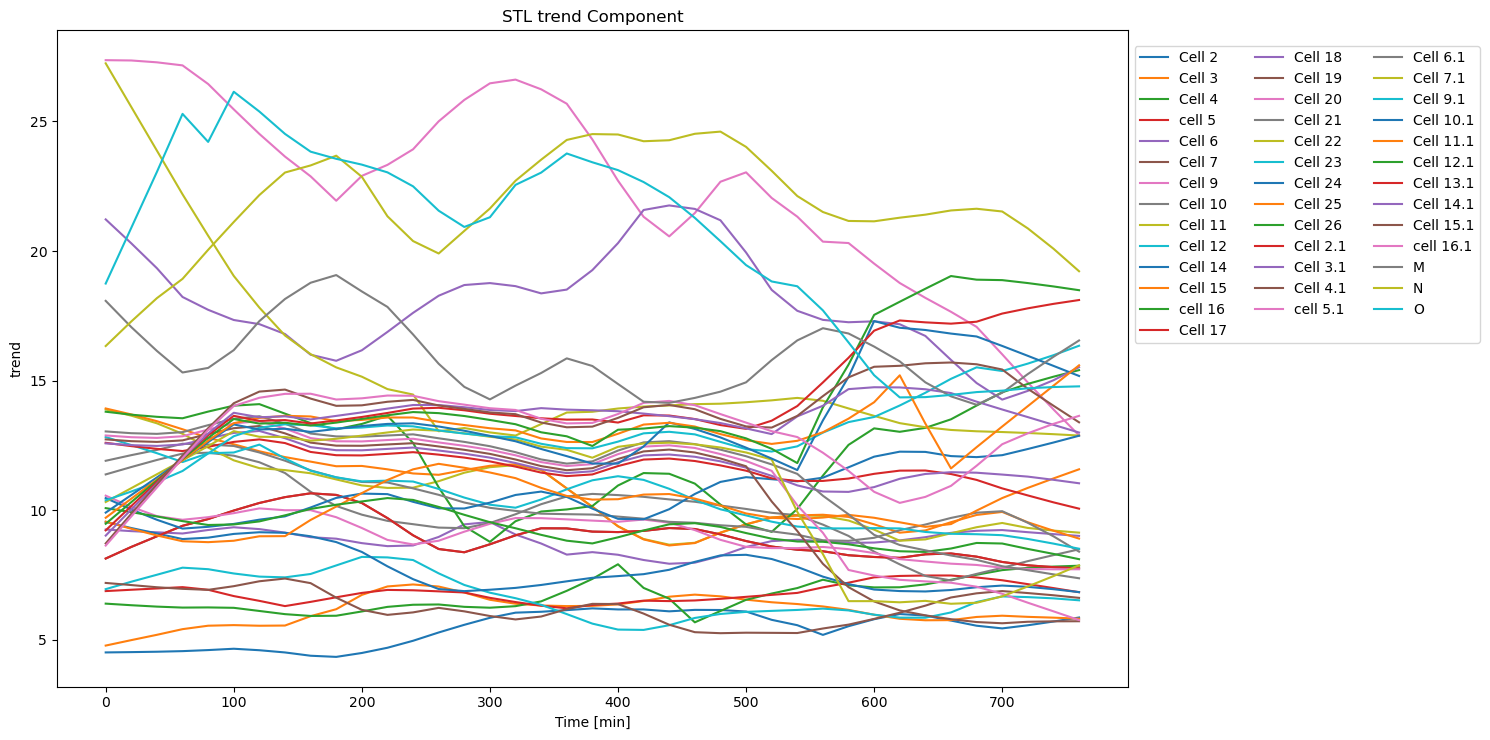

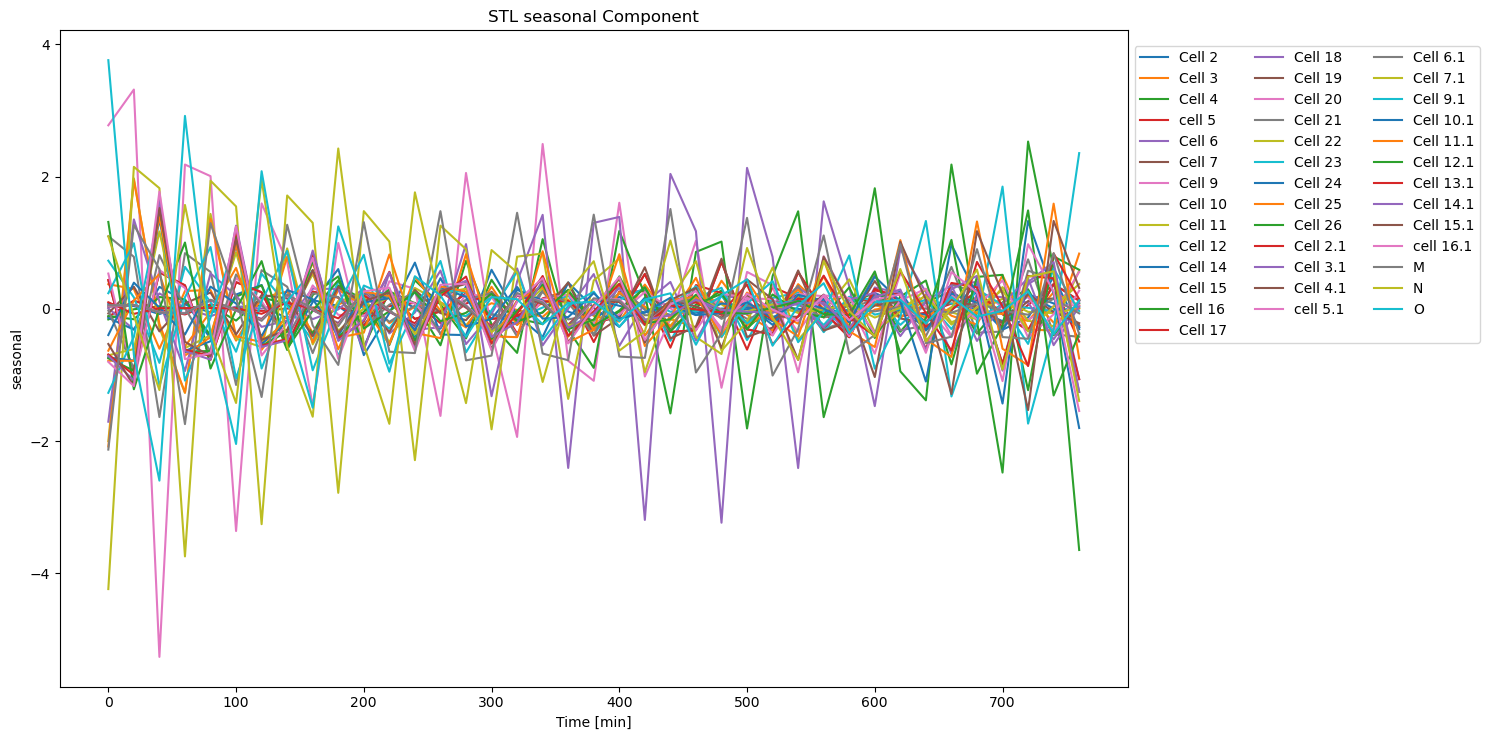

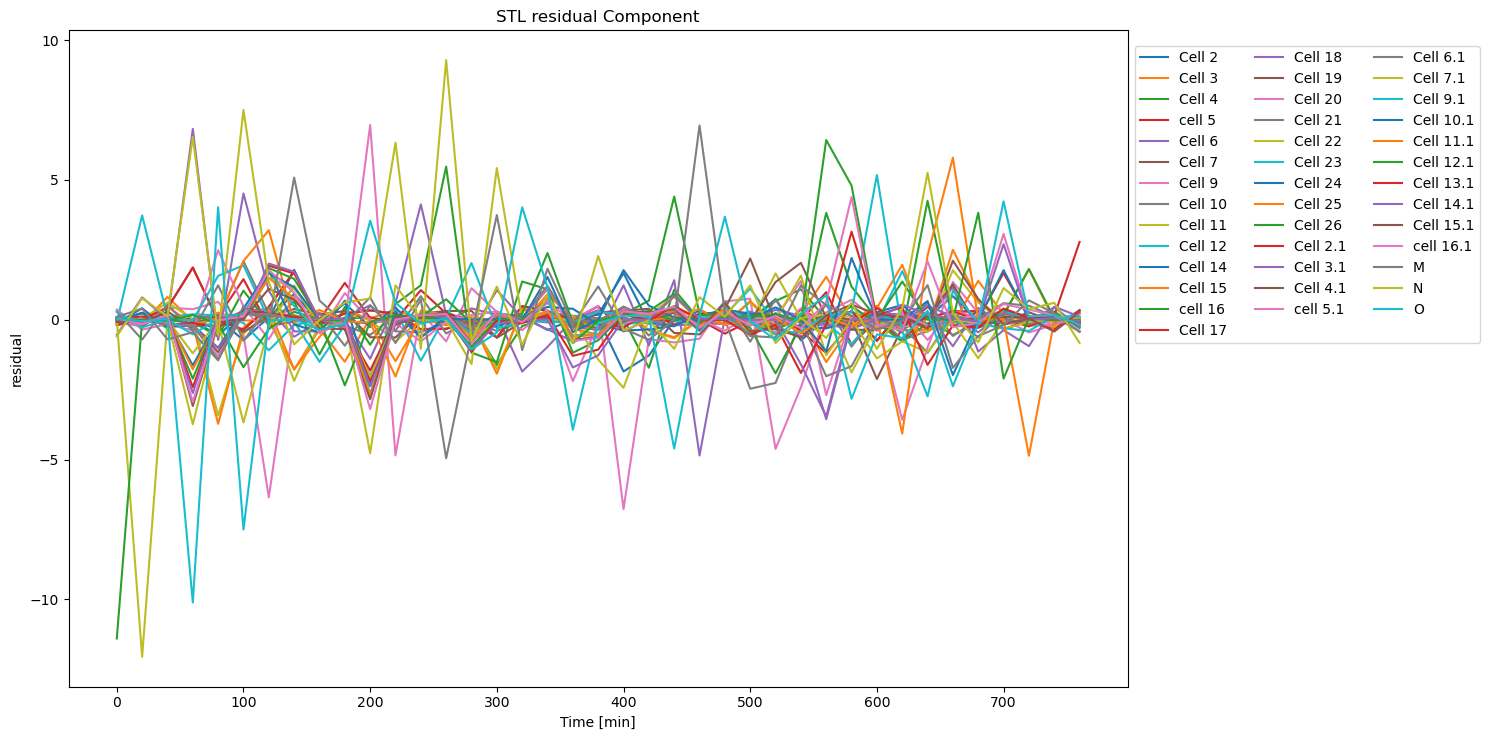

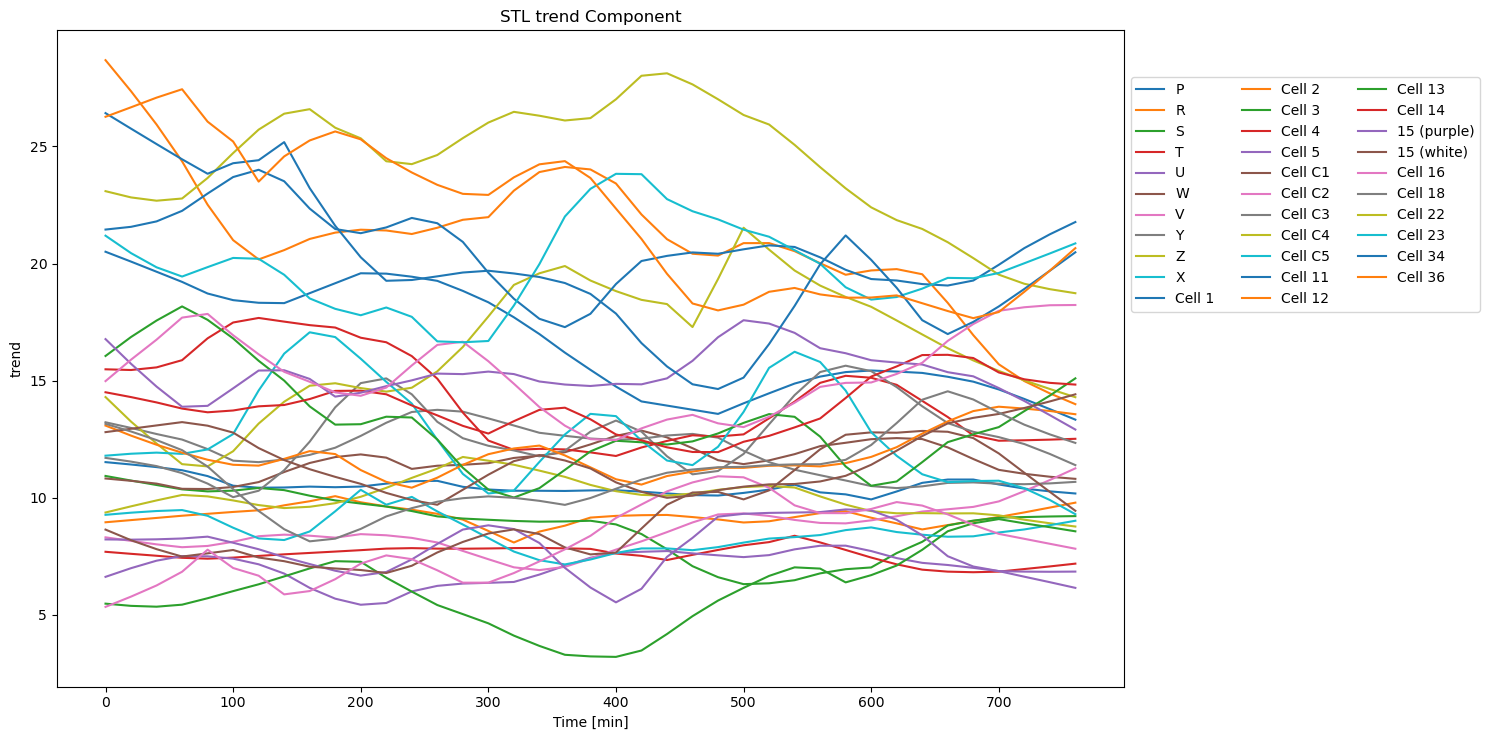

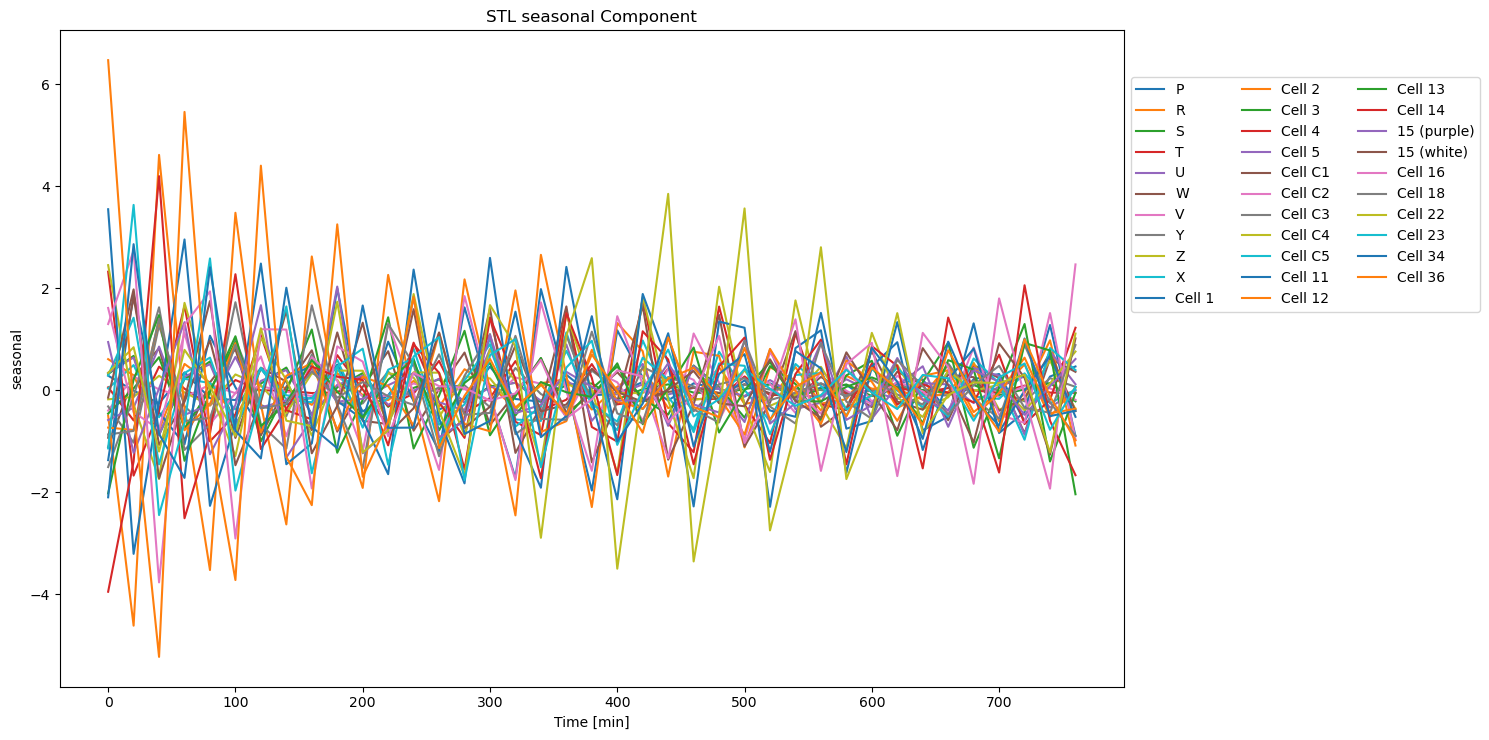

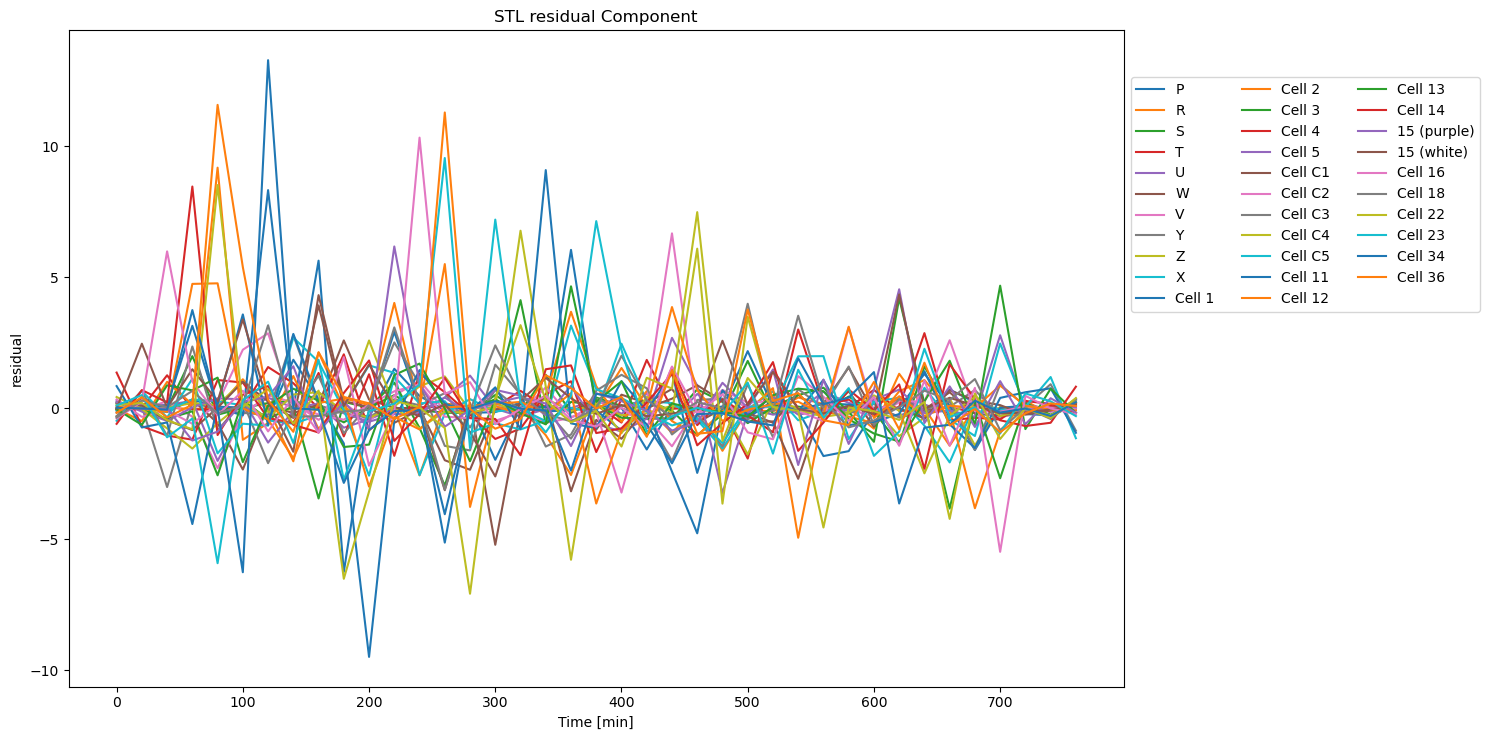

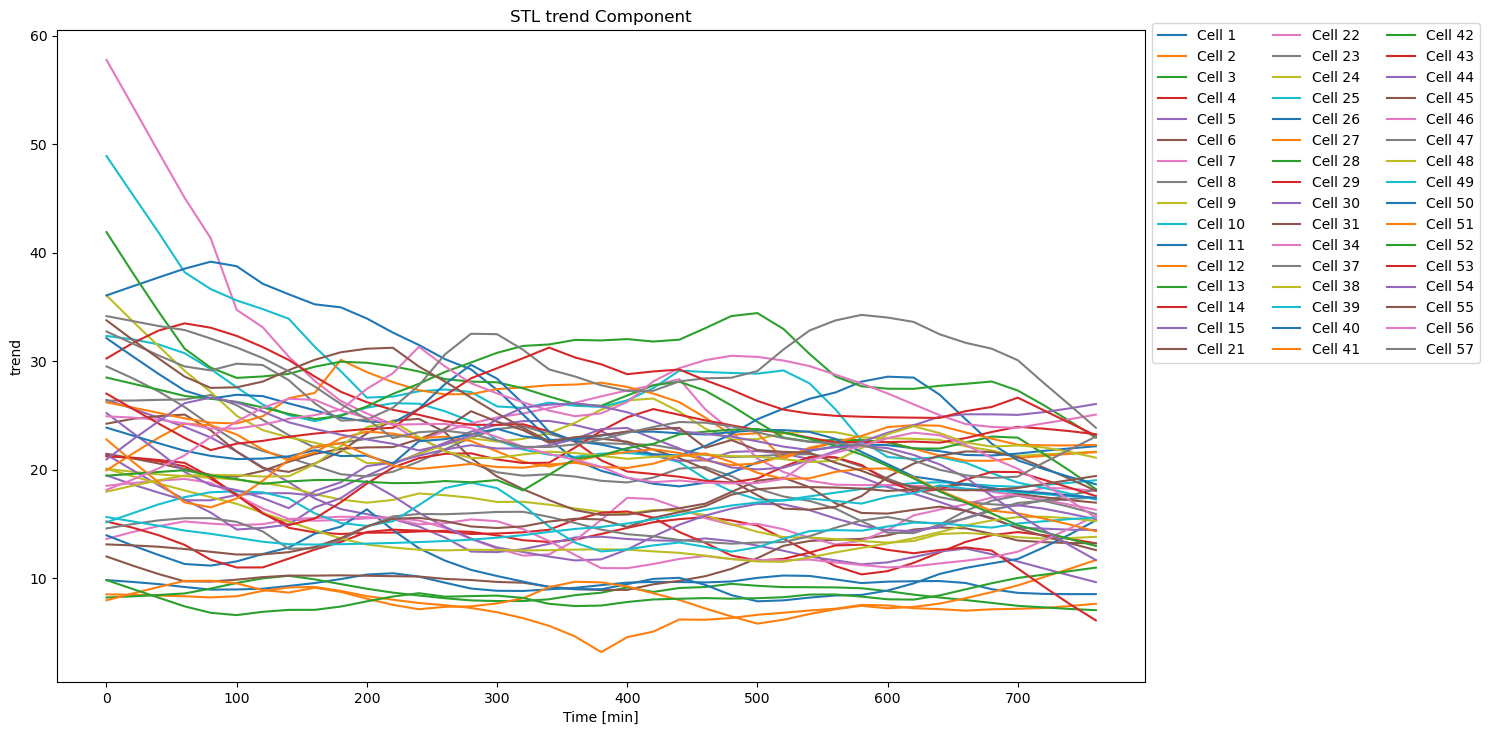

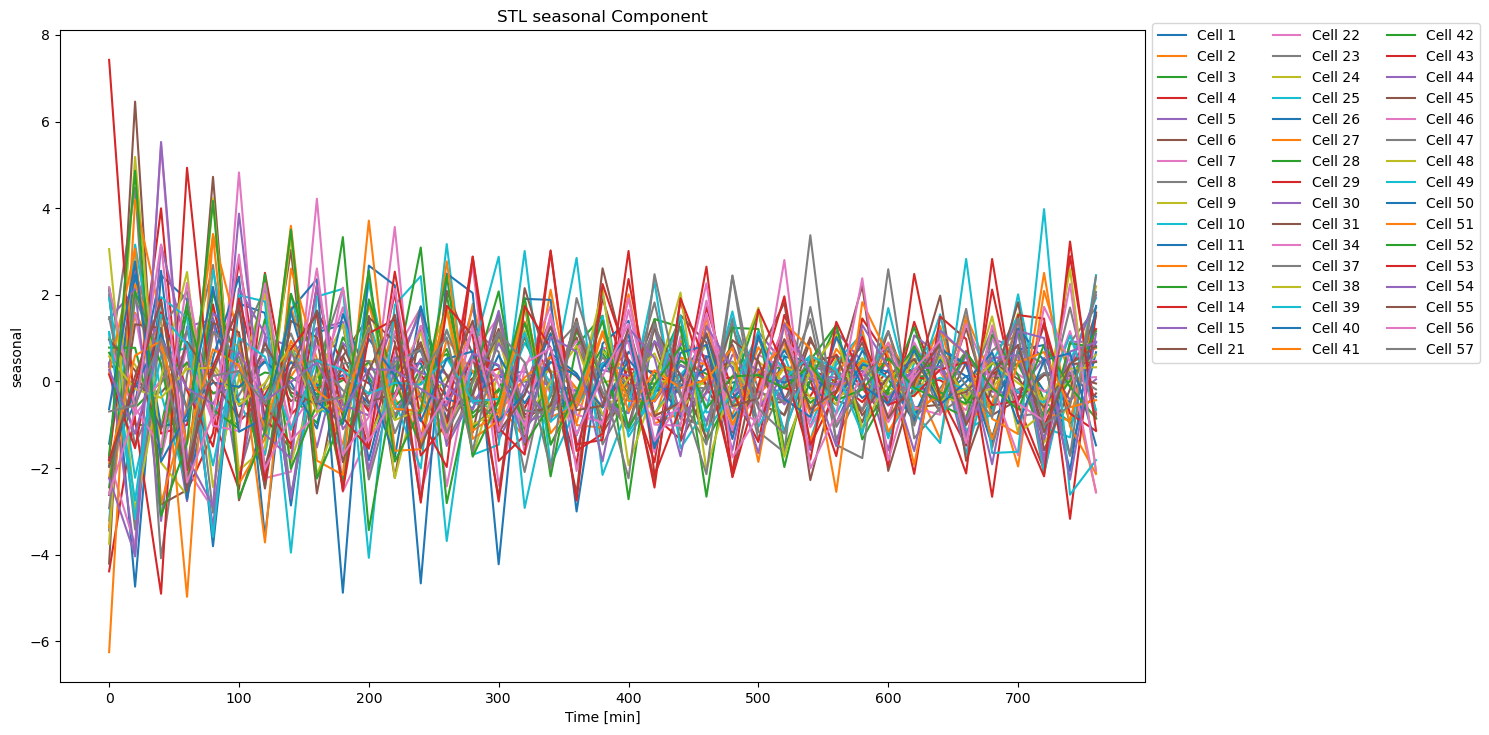

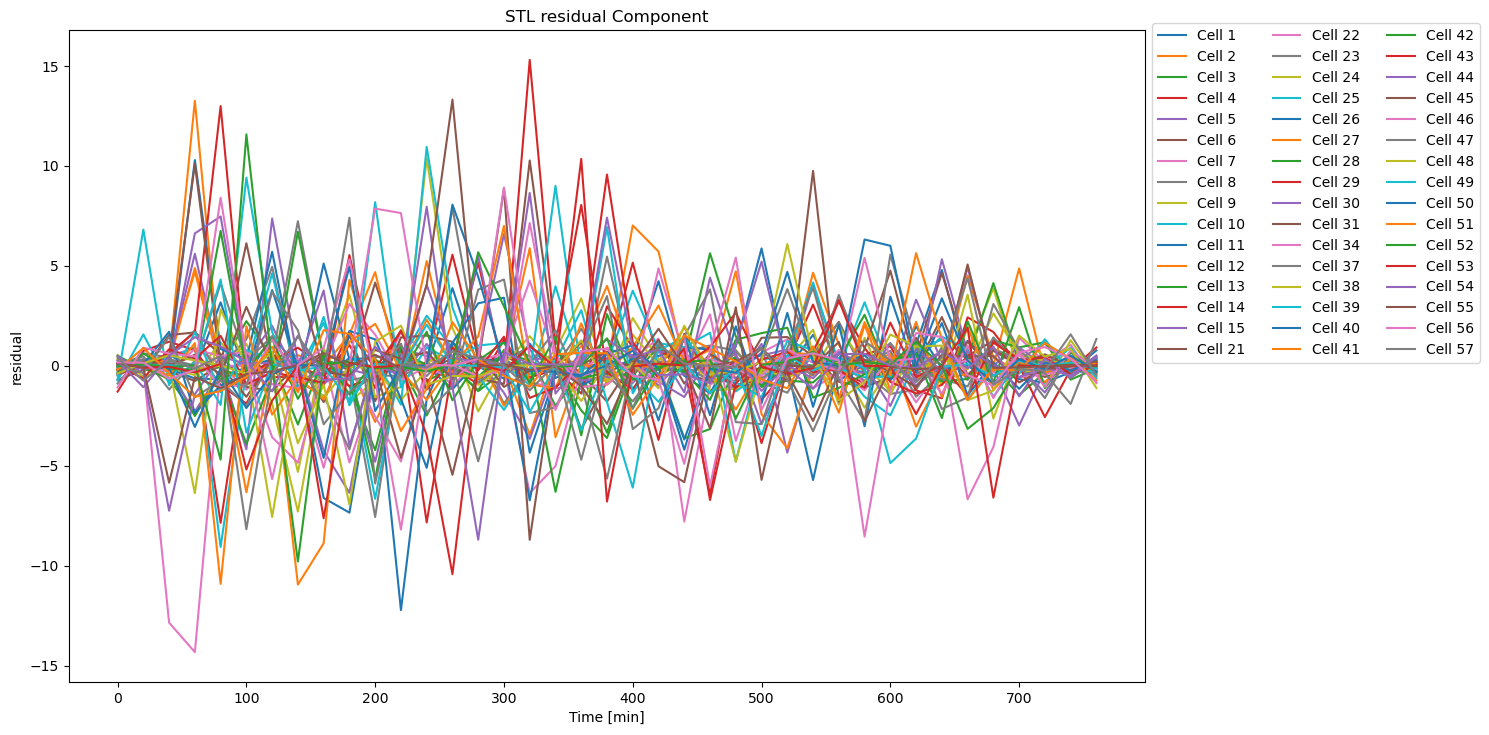

In [10]:
# plot stl elements function
def plot_stl_elements(df, element):
    plt.figure(figsize=(15, 7.5))
    for cell in df.columns.get_level_values(1).unique():
        plt.plot(df.index, df[element][cell], label=cell)
    plt.title(f'STL {element} Component')
    plt.xlabel('Time [min]')
    plt.ylabel(element)
    plt.legend(bbox_to_anchor=(1, 0.75), loc='center left', ncol=3)
    plt.tight_layout()
    plt.show()
    
# plot stl elements for mov1 decomposition results
plot_stl_elements(area_mov1_stl_concat_df, 'trend')
plot_stl_elements(area_mov1_stl_concat_df, 'seasonal')
plot_stl_elements(area_mov1_stl_concat_df, 'residual')

# plot stl elements for mov2 decomposition results
plot_stl_elements(area_mov2_stl_concat_df, 'trend')
plot_stl_elements(area_mov2_stl_concat_df, 'seasonal')
plot_stl_elements(area_mov2_stl_concat_df, 'residual')

# plot stl elements for mov3 decomposition results
plot_stl_elements(area_mov3_stl_concat_df, 'trend')
plot_stl_elements(area_mov3_stl_concat_df, 'seasonal')
plot_stl_elements(area_mov3_stl_concat_df, 'residual')

## 2. Rolling Stats

Contributor: Vasav

### a. Rolling mean

dfs, where [N] = 1,2,3
- rolling_mean_area_mov[N]_results
- rolling_mean_delta_mov[N]_results


In [11]:
# rolling mean stats function 
def rolling_mean(df):
    df_rolling_mean = pd.DataFrame()
    for col in df.columns: 
        df_rolling_mean[col] = df[col].rolling(window=3, min_periods=1).mean()
    return df_rolling_mean

# Mov.1 Rolling Mean Stats results
rolling_mean_area_mov1_results = rolling_mean(area_imputation_df)
rolling_mean_delta_mov1_results = rolling_mean(delta_imputation_df)

# Mov.2 Rolling Mean Stats results
rolling_mean_area_mov2_results = rolling_mean(area_imputation_mov2_df)
rolling_mean_delta_mov2_results = rolling_mean(delta_imputation_mov2_df)

# Mov.3 Rolling Mean Stats results
rolling_mean_area_mov3_results = rolling_mean(area_imputation_mov3_df)
rolling_mean_delta_mov3_results = rolling_mean(delta_imputation_mov3_df)

In [15]:
delta_imputation_mov3_df.tail()

Cell            Cell 1  Cell 2  Cell 3  Cell 4  Cell 5  Cell 6  Cell 7  \
Interval [min]                                                           
680             -1.616  -0.692  -1.385  -3.078  -3.770 -0.8465  4.1551   
700              1.154  -1.385   0.000  -1.385  -0.385  1.8468 -0.5386   
720             -0.616   1.539   1.000   3.848   2.385 -2.3084  2.4623   
740              0.308   1.231   0.231  -4.002  -0.769  1.3850 -4.1551   
760              1.154  -0.231   2.077   2.694   2.385  1.6928 -1.0773   

Cell            Cell 8  Cell 9  Cell 10  ...  Cell 48  Cell 49  Cell 50  \
Interval [min]                           ...                              
680             0.3078 -2.7701   1.0003  ...   2.3854   0.6156  -0.6926   
700            -2.9240 -2.9240  -3.5396  ...  -1.6159   5.1554   0.7695   
720             1.1542  0.9234   2.9240  ...   0.6925  -6.6174   0.6156   
740             0.0000  3.2317   2.0006  ...  -2.4623   0.3078  -3.1548   
760            -1.3850  2.0006  -4.9246  ...  -0.2308  -0.7694   4.0012   

Cell            Cell 51  Cell 52  Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
Interval [min]                                                                 
680              1.3851   0.5386   3.8474  -1.0773   0.8465  -1.1542   3.1548  
700              1.1542   0.8464  -2.6162   0.2309  -1.6159  -1.5390  -1.2312  
720             -2.6162  -1.5389   4.3090  -5.6171   2.0006   1.0773   3.4626  
740             -1.5389  -1.4620  -5.5402   3.0778   0.7695  -7.0791   1.7698  
760              0.2308   1.7698  -2.6162   0.3078   3.6934   2.0006  -1.5389  

[5 rows x 48 columns]

In [16]:
delta_imputation_mov3_df.head()

Cell            Cell 1  Cell 2  Cell 3  Cell 4  Cell 5  Cell 6  Cell 7  \
Interval [min]                                                           
0               -6.848   3.847  -3.001   4.770   5.156 -1.7698  2.4622   
20               7.540  -0.769   0.000  -4.540  -2.309 -1.0772 -2.3853   
40              -1.616   1.846   2.693   0.308   1.000 -0.4617  3.3857   
60              -2.539  -1.385  -1.770  -6.771  -2.231  0.0769 -1.6159   
80               1.924  -1.769   2.463   4.309  -6.002  6.3866 -2.5393   

Cell             Cell 8  Cell 9  Cell 10  ...  Cell 48  Cell 49  Cell 50  \
Interval [min]                            ...                              
0                4.5399 -2.0006   6.8483  ...   0.3078  -4.1551   2.5393   
20             -10.1570 -1.1542  -3.8473  ...   0.6925   3.8473  -5.3863   
40               5.6941  0.8464  -2.3854  ...   0.8464  -1.1542  -2.5392   
60               2.6931  1.5389  -6.4635  ...  -0.1539   1.2312   5.3862   
80              -4.4629 -2.5392   4.1551  ...  -1.3081  -5.0785  -5.6171   

Cell            Cell 51  Cell 52  Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
Interval [min]                                                                 
0                1.5390   6.8483   0.1539  -1.0003   0.0770   2.8470  -1.4620  
20              -2.8471  -7.9255   0.6156   5.4632  -5.7710   4.0782   2.0776  
40              -5.3862   1.9236  -5.5402   1.4620  -0.2308  -3.8473  -2.3854  
60               2.0006   0.3848   1.6929  -0.3078   0.6155  11.8497   0.6156  
80               1.1542   9.0797  -3.3087   0.0000   2.3084  -2.8470  -9.3875  

[5 rows x 48 columns]

### b. Rolling median

dfs, where [N] = 1,2,3
- rolling_median_area_mov[N]_results
- rolling_median_delta_mov[N]_results


In [12]:
# rolling median stats function 
def rolling_median(df):
    df_rolling_median = pd.DataFrame()
    for col in df.columns: 
        df_rolling_median[col] = df[col].rolling(window=3, min_periods=1).median()
    return df_rolling_median

# Mov.1 Rolling Median Stats results
rolling_median_area_mov1_results = rolling_median(area_imputation_df)
rolling_median_delta_mov1_results = rolling_median(delta_imputation_df)

# Mov.2 Rolling Median Stats results
rolling_median_area_mov2_results = rolling_median(area_imputation_mov2_df)
rolling_median_delta_mov2_results = rolling_median(delta_imputation_mov2_df)

# Mov.3 Rolling Median Stats results
rolling_median_area_mov3_results = rolling_median(area_imputation_mov3_df)
rolling_median_delta_mov3_results = rolling_median(delta_imputation_mov3_df)

### c. Rolling standard deviation

dfs, where [N] = 1,2,3
- rolling_std_area_mov[N]_results
- rolling_std_delta_mov[N]_results


In [13]:
# rolling std. dev stats function 
def rolling_std(df):
    df_rolling_std = pd.DataFrame()
    for col in df.columns: 
        df_rolling_std[col] = df[col].rolling(window=3, min_periods=1).std()
    return df_rolling_std

# Mov.1 Rolling Standard Deviation Stats results
rolling_std_area_mov1_results = rolling_std(area_imputation_df)
rolling_std_delta_mov1_results = rolling_std(delta_imputation_df)

# Mov.2 Rolling Standard Deviation Stats results
rolling_std_area_mov2_results = rolling_std(area_imputation_mov2_df)
rolling_std_delta_mov2_results = rolling_std(delta_imputation_mov2_df)

# Mov.3 Rolling Standard Deviation Stats results
rolling_std_area_mov3_results = rolling_std(area_imputation_mov3_df)
rolling_std_delta_mov3_results = rolling_std(delta_imputation_mov3_df)

In [14]:
delta_imputation_mov3_df.head(10)

Cell            Cell 1  Cell 2  Cell 3  Cell 4  Cell 5  Cell 6  Cell 7  \
Interval [min]                                                           
0               -6.848   3.847  -3.001   4.770   5.156 -1.7698  2.4622   
20               7.540  -0.769   0.000  -4.540  -2.309 -1.0772 -2.3853   
40              -1.616   1.846   2.693   0.308   1.000 -0.4617  3.3857   
60              -2.539  -1.385  -1.770  -6.771  -2.231  0.0769 -1.6159   
80               1.924  -1.769   2.463   4.309  -6.002  6.3866 -2.5393   
100              1.847  -0.539   1.077  -2.232   6.925 -5.1554  3.6165   
120             -5.694   4.001  -1.847  -0.230  -5.771 -1.0773 -1.6928   
140              3.616  -2.308  -1.077  -2.309  -2.000  0.9234  0.8464   
160              1.616  -1.693   1.770   3.463  -2.616  0.0769 -3.3087   
180             -3.232  -0.077  -1.924  -2.078   0.000  3.0779  0.0770   

Cell             Cell 8  Cell 9  Cell 10  ...  Cell 48  Cell 49  Cell 50  \
Interval [min]                            ...                              
0                4.5399 -2.0006   6.8483  ...   0.3078  -4.1551   2.5393   
20             -10.1570 -1.1542  -3.8473  ...   0.6925   3.8473  -5.3863   
40               5.6941  0.8464  -2.3854  ...   0.8464  -1.1542  -2.5392   
60               2.6931  1.5389  -6.4635  ...  -0.1539   1.2312   5.3862   
80              -4.4629 -2.5392   4.1551  ...  -1.3081  -5.0785  -5.6171   
100              4.3859  0.2308   2.0006  ...   1.4620   2.6162   2.0776   
120             -6.2326 -5.0015  -2.6162  ...  -3.6934  -2.2315   3.0778   
140             -1.6929  5.0785  -2.8470  ...   2.5392   1.7698  -1.5389   
160              0.1539 -3.8474   0.6925  ...  -4.0012  -1.9237   3.9243   
180             -6.6943  1.9237  -3.6934  ...  11.5420   1.3851  -5.2324   

Cell            Cell 51  Cell 52  Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
Interval [min]                                                                 
0                1.5390   6.8483   0.1539  -1.0003   0.0770   2.8470  -1.4620  
20              -2.8471  -7.9255   0.6156   5.4632  -5.7710   4.0782   2.0776  
40              -5.3862   1.9236  -5.5402   1.4620  -0.2308  -3.8473  -2.3854  
60               2.0006   0.3848   1.6929  -0.3078   0.6155  11.8497   0.6156  
80               1.1542   9.0797  -3.3087   0.0000   2.3084  -2.8470  -9.3875  
100              1.6928 -10.4648  -0.3078  -3.4626  -3.0778  -9.7722   6.0019  
120              1.6928  -4.9246   5.1554   2.2315   3.6164   7.7716   1.9236  
140              3.1549   4.3091  -6.5405  -2.3854   2.9240   4.1551  -4.3859  
160             -0.3848   1.4619   3.9243  -1.5389  -3.4626  -0.8464   6.2326  
180             -0.3847   2.9240   3.6165   2.0775   3.0009  -5.8479 -13.0809  

[10 rows x 48 columns]

In [20]:
# plot rolling mean stats function
def plot_rolling_mean_stats(df):
    plt.figure(figsize=(15, 7.5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title('Rolling Mean of Cell Area')
    plt.xlabel('Time [min]')
    plt.ylabel('Rolling Mean')
    plt.legend(bbox_to_anchor=(1, 0.75), loc='center left', ncol=3)
    plt.tight_layout()
    plt.show()

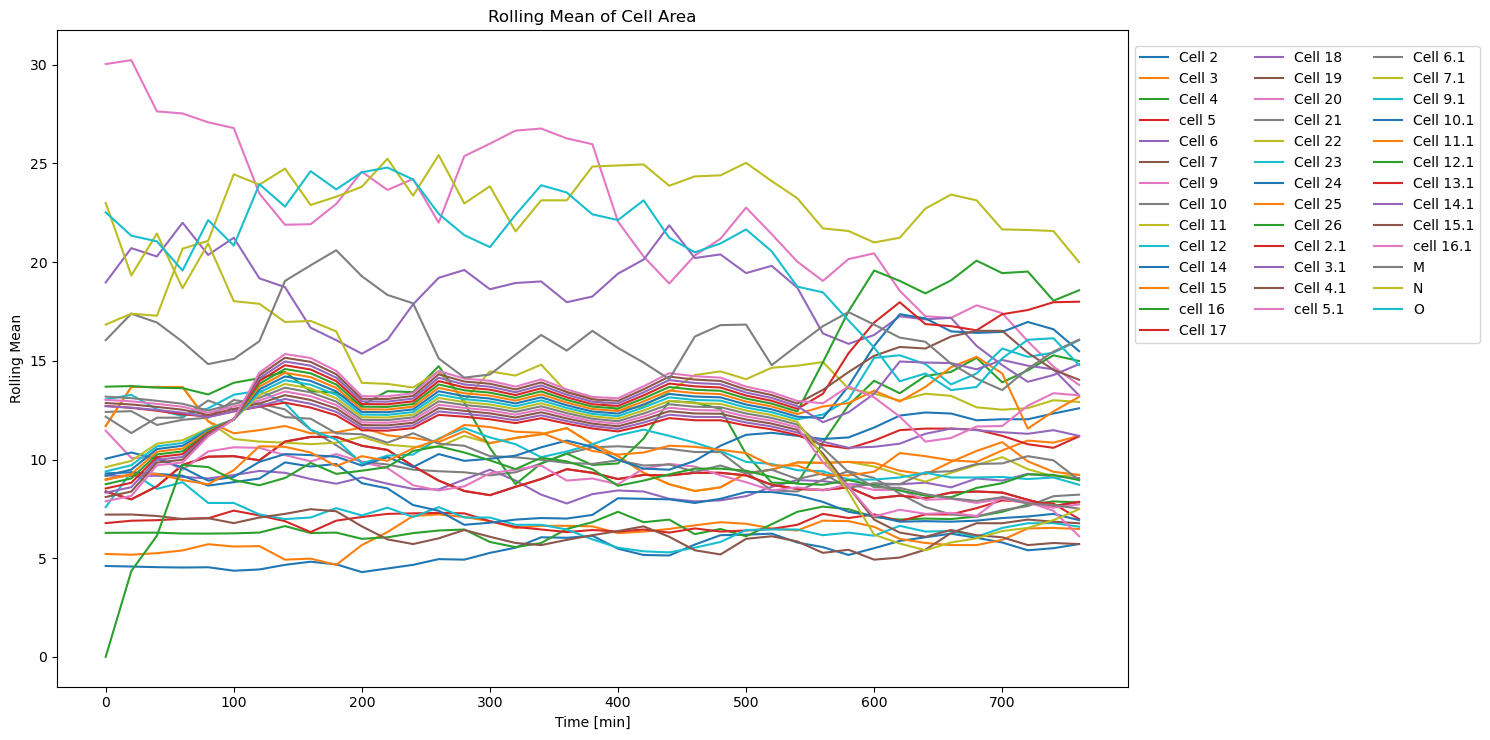

In [21]:
plot_rolling_mean_stats(rolling_mean_area_mov1_results)

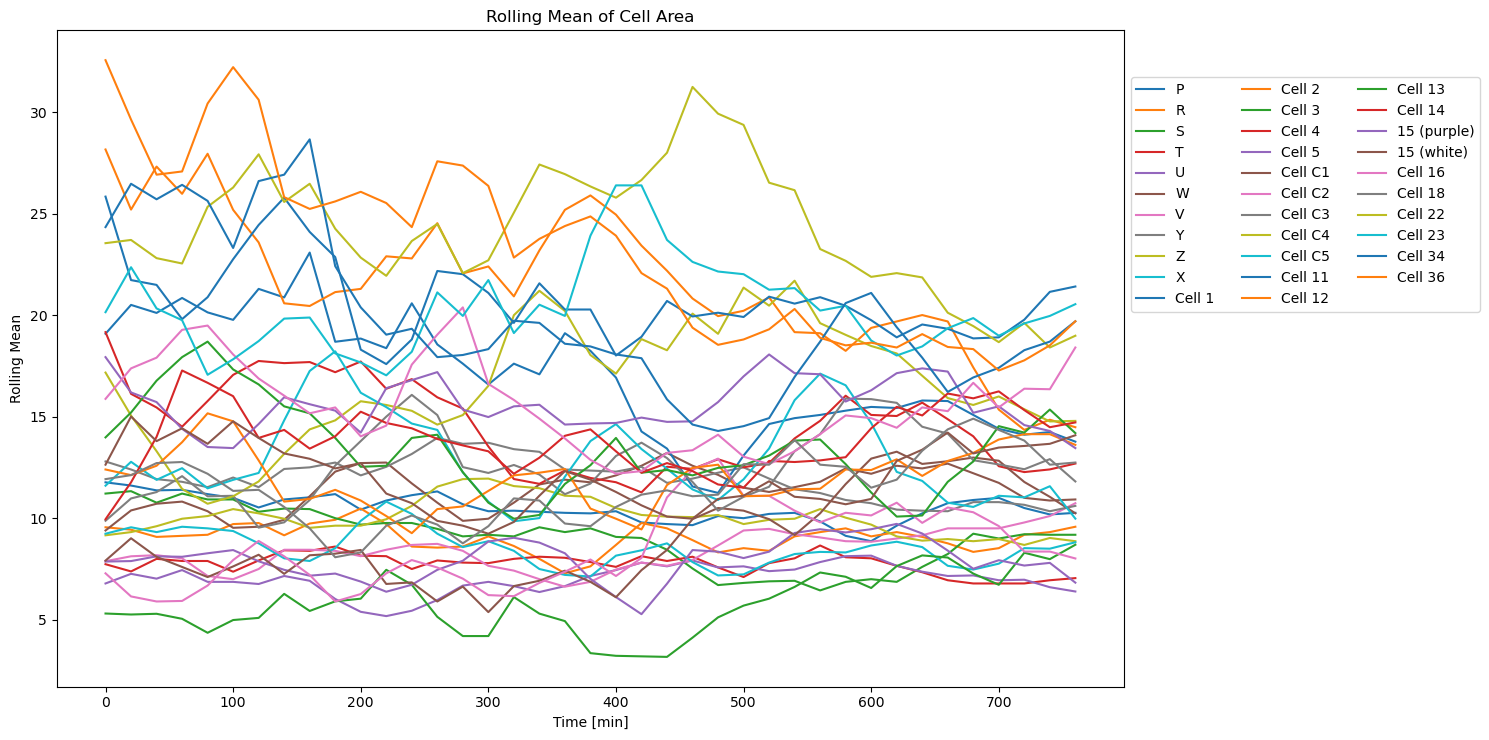

In [22]:
plot_rolling_mean_stats(rolling_mean_area_mov2_results)

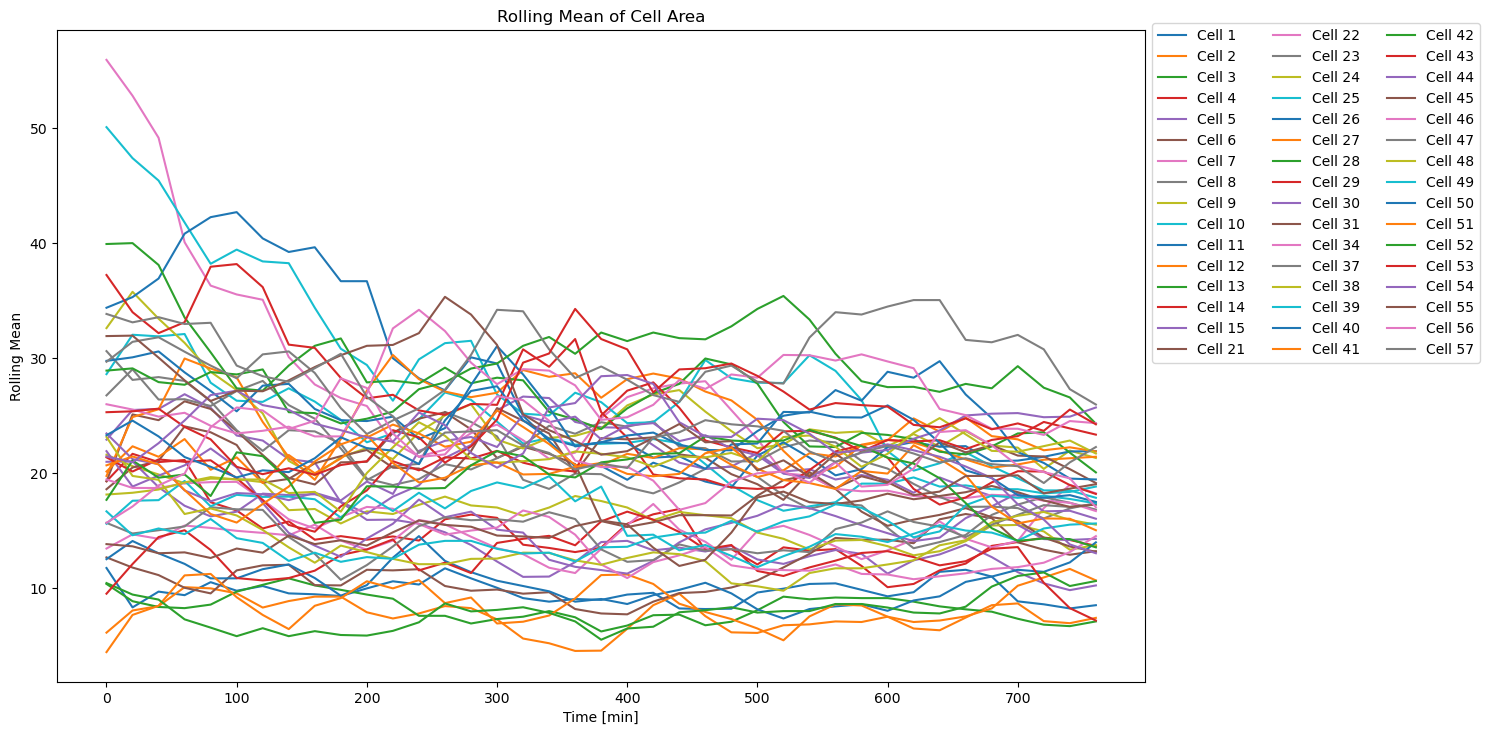

In [23]:
plot_rolling_mean_stats(rolling_mean_area_mov3_results)

In [20]:
rolling_std_delta_mov3_results.head()

Cell 1    Cell 2    Cell 3    Cell 4    Cell 5    Cell 6  \
Interval [min]                                                                
0                     NaN       NaN       NaN       NaN       NaN       NaN   
20              10.173852  3.264005  2.122027  6.583164  5.278552  0.489742   
40               7.282636  2.314796  2.848388  4.656333  3.740500  0.654429   
60               5.571812  1.715471  2.247351  3.619224  1.888338  0.577477   
80               2.355911  1.985575  2.512952  5.610803  3.504469  3.807922   

                  Cell 7     Cell 8    Cell 9   Cell 10  ...   Cell 48  \
Interval [min]                                           ...             
0                    NaN        NaN       NaN       NaN  ...       NaN   
20              3.427700  10.392278  0.598495  7.562931  ...  0.272024   
40              3.099880   8.837311  1.461974  5.799342  ...  0.277419   
60              3.133486   8.420099  1.398496  2.066098  ...  0.538621   
80              3.187849   5.218221  2.182229  5.356673  ...  1.078166   

                 Cell 49   Cell 50   Cell 51    Cell 52   Cell 53   Cell 54  \
Interval [min]                                                                
0                    NaN       NaN       NaN        NaN       NaN       NaN   
20              5.658551  5.604246  3.101441  10.446654  0.326471  4.570385   
40              4.042664  4.014812  3.503410   7.522440  3.428552  3.262140   
60              2.501637  5.582184  3.753044   5.298329  3.902396  2.956525   
80              3.185974  5.676825  4.042648   4.640024  3.703902  0.945549   

                 Cell 55   Cell 56   Cell 57  
Interval [min]                                
0                    NaN       NaN       NaN  
20              4.135160  0.870590  2.502875  
40              3.291091  4.265033  2.355837  
60              3.468848  7.848626  2.275295  
80              1.292908  8.788149  5.133183  

[5 rows x 48 columns]

## 3. Next Feature

Contributor: 

In [58]:
import pandas as pd

# Load the CSV file
file_path = './multi_level_combined_imputed_final_movie_level.csv'
df = pd.read_csv(file_path, skiprows=[0])

# Extract the second row (which indicates whether the column is "area" or "delta")
column_types = df.iloc[0]

# Filter columns based on whether they are "area" or "delta"
area_columns = df.columns[column_types == "area"]
delta_columns = df.columns[column_types == "delta"]

# Create separate DataFrames for "area" and "delta"
df_area = df[area_columns].iloc[1:]  # Remove the row used for filtering
df_delta = df[delta_columns].iloc[1:]  # Remove the row used for filtering

# If you want to save the DataFrames to new CSV files:
df_area.to_csv('area_columns.csv', index=False)
df_delta.to_csv('delta_columns.csv', index=False)


In [64]:
# Load the area dataset
df = pd.read_csv('./area_columns.csv')

df.head()



Cell 2  Cell 3    Cell 4    cell 5    Cell 6   Cell 7   Cell 9  Cell 10  \
0       NaN     NaN       NaN       NaN       NaN      NaN      NaN      NaN   
1  4.604450   5.217  6.284200  6.778250  9.189250   8.3789  30.0376  12.4103   
2  4.553060   5.138  6.297367  7.019340  9.137800   7.5884  30.4328  12.4893   
3  4.479283   5.409  6.303950  6.982450  9.209000   9.9598  22.4491  10.3551   
4  4.550800   5.632  6.149800  6.978686  9.011429  11.6198  29.7214  13.2007   

   Cell 11  Cell 12  ...  Cell 48  Cell 49  Cell 50  Cell 51  Cell 52  \
0      NaN      NaN  ...      NaN      NaN      NaN      NaN      NaN   
1  11.6988   7.5884  ...  18.1594  16.6974  23.3148  20.6986  17.6977   
2  15.6512  11.1455  ...  18.4672  12.5423  25.8541  22.2376  24.5460   
3  13.6750   6.7980  ...  19.1597  16.3896  20.4678  19.3905  16.6205   
4  11.6988   8.6160  ...  20.0061  15.2354  17.9286  14.0043  18.5441   

   Cell 53  Cell 54  Cell 55  Cell 56  Cell 57  
0      NaN      NaN      NaN      NaN      NaN  
1  25.3154  21.4681  31.9328  15.6971  33.8565  
2  25.4693  20.4678  32.0098  18.5441  32.3945  
3  26.0849  25.9310  26.2388  22.6223  34.4721  
4  20.5447  27.3930  26.0080  18.7750  32.0867  

[5 rows x 120 columns]

In [65]:
# Transpose the DataFrame
transposed_df = df.T

# Display the first few rows of the transposed DataFrame
print(transposed_df.head())

        0        1         2         3         4         5         6   \
Cell 2 NaN  4.60445  4.553060  4.479283  4.550800  4.594563  3.952300   
Cell 3 NaN  5.21700  5.138000  5.409000  5.632000  6.087000  5.059000   
Cell 4 NaN  6.28420  6.297367  6.303950  6.149800  6.284183  6.346286   
cell 5 NaN  6.77825  7.019340  6.982450  6.978686  7.114187  8.141800   
Cell 6 NaN  9.18925  9.137800  9.209000  9.011429  8.902750  9.723000   

              7       8       9   ...      30      31      32      33      34  \
Cell 2  4.742800  5.2961  4.4266  ...  5.1380  6.0075  6.4818  5.6913  6.5608   
Cell 3  5.691000  4.0310  5.2170  ...  5.8490  6.0870  6.0080  5.2170  5.7700   
Cell 4  6.264412  7.2723  5.2961  ...  7.1142  7.1142  6.6399  7.2723  7.0351   
cell 5  6.244700  6.2447  6.4818  ...  6.4818  7.5094  6.6399  7.5094  7.5094   
Cell 6  9.644000  8.6160  8.7740  ...  8.3000  9.2480  8.6950  8.5370  8.5370   

             35      36      37      38      39  
Cell 2   5.8494  4.9799 

In [66]:
transposed_df.to_csv('area_columns_transposed.csv', index=False)

In [67]:
df = transposed_df.copy()

In [69]:
# Descriptive Statistics Features
df['mean'] = df.mean(axis=1)
df['std_dev'] = df.std(axis=1)
df['min'] = df.min(axis=1)
df['max'] = df.max(axis=1)
df['range'] = df['max'] - df['min']
df['skewness'] = df.skew(axis=1)
df['kurtosis'] = df.kurtosis(axis=1)



In [70]:
df.tail(10)

0        1        2        3        4        5        6        7  \
Cell 48 NaN  18.1594  18.4672  19.1597  20.0061  19.8522  18.5441  20.0061   
Cell 49 NaN  16.6974  12.5423  16.3896  15.2354  16.4666  11.3881  14.0043   
Cell 50 NaN  23.3148  25.8541  20.4678  17.9286  23.3148  17.6977  19.7753   
Cell 51 NaN  20.6986  22.2376  19.3905  14.0043  16.0049  17.1591  18.8519   
Cell 52 NaN  17.6977  24.5460  16.6205  18.5441  18.9289  28.0086  17.5438   
Cell 53 NaN  25.3154  25.4693  26.0849  20.5447  22.2376  18.9289  18.6211   
Cell 54 NaN  21.4681  20.4678  25.9310  27.3930  27.0852  27.0852  23.6226   
Cell 55 NaN  31.9328  32.0098  26.2388  26.0080  26.6235  28.9319  25.8541   
Cell 56 NaN  15.6971  18.5441  22.6223  18.7750  30.6247  27.7777  18.0055   
Cell 57 NaN  33.8565  32.3945  34.4721  32.0867  32.7023  23.3148  29.3167   

               8        9  ...       37       38       39       mean  \
Cell 48  16.3127  18.8519  ...  22.0837  22.7762  20.3139  21.241215   
Cell 49  11.7728  13.5426  ...  21.6989  15.0815  15.3893  14.923692   
Cell 50  22.8531  21.3142  ...  18.1594  18.7750  15.6202  22.290838   
Cell 51  20.5447  23.6996  ...  17.3130  14.6968  13.1579  19.414215   
Cell 52  12.6192  16.9283  ...  15.0815  13.5426  12.0806  19.501033   
Cell 53  23.7765  17.2360  ...  23.2379  27.5469  22.0067  25.242426   
Cell 54  25.8541  23.4687  ...  15.7741  10.1570  13.2348  22.661767   
Cell 55  29.4705  32.3945  ...  17.4669  19.4675  20.2370  24.494667   
Cell 56  25.7771  29.9322  ...  18.6980  19.7753  12.6962  21.515462   
Cell 57  31.2403  26.8544  ...  19.3905  22.8531  24.6229  24.380226   

          std_dev       min      max      range  skewness  kurtosis  
Cell 48  2.606182  2.606182  26.3927  23.786518 -2.442855  7.022639  
Cell 49  2.367675  2.367675  21.6989  19.331225 -1.224788  4.461273  
Cell 50  3.377483  3.377483  31.3942  28.016717 -1.522432  4.718751  
Cell 51  2.980183  2.980183  24.1612  21.181017 -1.901763  5.194110  
Cell 52  3.722384  3.722384  28.0086  24.286216 -1.087247  2.834644  
Cell 53  4.287146  4.287146  37.9347  33.647554 -1.039350  3.580525  
Cell 54  4.462080  4.462080  31.3942  26.932120 -1.320124  2.815788  
Cell 55  5.560023  5.560023  41.3973  35.837277 -0.047500  1.533060  
Cell 56  4.362593  4.362593  30.7786  26.416007 -0.776637  2.460640  
Cell 57  4.639580  4.639580  34.4721  29.832520 -0.767587  2.927358  

[10 rows x 47 columns]

In [71]:
df.to_csv('area_columns_descriptive_features.csv', index=False)

In [74]:
import pandas as pd
from statsmodels.tsa.stattools import acf


file_path = './area_columns_transposed.csv'
data = pd.read_csv(file_path, header=0)

# Function to calculate autocorrelation for each row
def calculate_autocorrelation(df, max_lag):
    autocorr_features = pd.DataFrame()
    for lag in range(1, max_lag + 1):
        autocorr_features[f'Autocorr_Lag_{lag}'] = df.apply(lambda row: acf(row, nlags=lag)[lag], axis=1)
    return autocorr_features

# Exclude the first column when calculating autocorrelation
numeric_data = data.iloc[:, 1:]

# Set the maximum lag for autocorrelation
max_lag = 5  # You can adjust this value based on your needs

# Calculate autocorrelation features
autocorr_features = calculate_autocorrelation(numeric_data, max_lag)

# Combine the original data with the new features
combined_data1 = pd.concat([data, autocorr_features], axis=1)

# Save the combined data to a new CSV file
csv_output_path = './Concat_Area_Data_with_autocorr_features.csv'
combined_data1.to_csv(csv_output_path, index=False)

print(f"Data with autocorrelation features saved to {csv_output_path}")

Data with autocorrelation features saved to ./Concat_Area_Data_with_autocorr_features.csv


In [75]:
df = pd.read_csv('./delta_columns.csv')

df.head()

Cell 2.2  Cell 3.2  Cell 4.2  cell 5.2  Cell 6.2  Cell 7.2  Cell 9.2  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1  0.158100   -0.2175 -1.976200 -0.553333 -0.316333  0.296425 -1.047363   
2  0.098800   -0.2688 -0.474300 -0.039525 -0.197750 -0.790500  0.395200   
3  0.031620    0.1580 -0.316200 -0.268760 -0.031600  2.371400 -7.983700   
4  0.171267    0.1580 -0.434775 -0.197617 -0.316167  1.660000  7.272300   

   Cell 10.2  Cell 11.2  Cell 12.2  ...  Cell 48.1  Cell 49.1  Cell 50.1  \
0        NaN        NaN        NaN  ...        NaN        NaN        NaN   
1  -0.306312  -0.118563  -0.069163  ...     0.3078    -4.1551     2.5393   
2   0.079000   3.952400   3.557100  ...     0.6925     3.8473    -5.3863   
3  -2.134200  -1.976200  -4.347500  ...     0.8464    -1.1542    -2.5392   
4   2.845600  -1.976200   1.818000  ...    -0.1539     1.2312     5.3862   

   Cell 51.1  Cell 52.1  Cell 53.1  Cell 54.1  Cell 55.1  Cell 56.1  Cell 57.1  
0        NaN        NaN        NaN        NaN        NaN        NaN        NaN  
1     1.5390     6.8483     0.1539    -1.0003     0.0770     2.8470    -1.4620  
2    -2.8471    -7.9255     0.6156     5.4632    -5.7710     4.0782     2.0776  
3    -5.3862     1.9236    -5.5402     1.4620    -0.2308    -3.8473    -2.3854  
4     2.0006     0.3848     1.6929    -0.3078     0.6155    11.8497     0.6156  

[5 rows x 120 columns]

In [77]:
# Transpose the DataFrame
transposed_delta_df = df.T

# Display the first few rows of the transposed DataFrame
print(transposed_delta_df.head())

          0         1         2        3         4         5         6   \
Cell 2.2 NaN  0.158100  0.098800  0.03162  0.171267  0.135514  0.128450   
Cell 3.2 NaN -0.217500 -0.268800  0.15800  0.158000  0.138250 -1.028000   
Cell 4.2 NaN -1.976200 -0.474300 -0.31620 -0.434775 -0.063240 -0.092233   
cell 5.2 NaN -0.553333 -0.039525 -0.26876 -0.197617 -0.011300 -0.158100   
Cell 6.2 NaN -0.316333 -0.197750 -0.03160 -0.316167 -0.225857 -0.029625   

                7         8       9   ...      30      31      32      33  \
Cell 2.2  0.790500  0.553300 -0.8695  ... -0.2371  0.8695  0.4743 -0.7905   
Cell 3.2  0.632000 -1.660000  1.1860  ... -1.9770  0.2380 -0.0790 -0.7910   
Cell 4.2 -0.225857 -0.276662 -1.9762  ...  0.0791  0.0000 -0.4743  0.6324   
cell 5.2 -1.897100  0.000000  0.2371  ... -1.1857  1.0276 -0.8695  0.8695   
Cell 6.2 -0.079000 -1.028000  0.1580  ... -0.3160  0.9480 -0.5530 -0.1580   

              34      35      36      37      38      39  
Cell 2.2  0.8695 -0.7114 -0

In [78]:
transposed_delta_df.to_csv('delta_columns_transposed.csv', index=False)

In [79]:
df = transposed_delta_df.copy()

In [80]:
# Descriptive Statistics Features
df['mean'] = df.mean(axis=1)
df['std_dev'] = df.std(axis=1)
df['min'] = df.min(axis=1)
df['max'] = df.max(axis=1)
df['range'] = df['max'] - df['min']
df['skewness'] = df.skew(axis=1)
df['kurtosis'] = df.kurtosis(axis=1)

In [81]:
df.head(10)

0         1         2        3         4         5         6  \
Cell 2.2  NaN  0.158100  0.098800  0.03162  0.171267  0.135514  0.128450   
Cell 3.2  NaN -0.217500 -0.268800  0.15800  0.158000  0.138250 -1.028000   
Cell 4.2  NaN -1.976200 -0.474300 -0.31620 -0.434775 -0.063240 -0.092233   
cell 5.2  NaN -0.553333 -0.039525 -0.26876 -0.197617 -0.011300 -0.158100   
Cell 6.2  NaN -0.316333 -0.197750 -0.03160 -0.316167 -0.225857 -0.029625   
Cell 7.2  NaN  0.296425 -0.790500  2.37140  1.660000 -2.766600  1.185700   
Cell 9.2  NaN -1.047363  0.395200 -7.98370  7.272300 -0.632400 -7.509400   
Cell 10.2 NaN -0.306312  0.079000 -2.13420  2.845600 -0.395200  0.237100   
Cell 11.2 NaN -0.118563  3.952400 -1.97620 -1.976200 -1.264700  0.553300   
Cell 12.2 NaN -0.069163  3.557100 -4.34750  1.818000 -0.632300 -1.185700   

                  7         8       9  ...      37        38        39  \
Cell 2.2   0.790500  0.553300 -0.8695  ...  0.3952  0.790500 -0.553300   
Cell 3.2   0.632000 -1.660000  1.1860  ...  1.5010 -1.422000 -0.238000   
Cell 4.2  -0.225857 -0.276662 -1.9762  ...  0.1581 -0.632400  0.316200   
cell 5.2  -1.897100  0.000000  0.2371  ... -1.4228  0.079000 -1.027600   
Cell 6.2  -0.079000 -1.028000  0.1580  ...  1.3440  0.079000 -1.660000   
Cell 7.2   0.948500  0.711400 -0.9485  ... -0.0790  0.316200  0.395200   
Cell 9.2  -1.818000  4.584600 -2.6875  ... -1.7390 -0.553400 -0.474200   
Cell 10.2 -0.395200 -0.711400 -1.9762  ...  0.8695 -0.553300 -0.079000   
Cell 11.2  0.316200 -1.027600  0.4743  ... -0.7114 -0.316200  1.264700   
Cell 12.2  0.079000  0.395300 -0.2372  ... -0.2371  0.118575  0.033886   

               mean   std_dev      min     max    range  skewness  kurtosis  
Cell 2.2   0.061122  0.626223  -1.5810  1.1066   2.6876  0.247702  2.131782  
Cell 3.2  -0.006924  0.817219  -1.9770  2.2920   4.2690  1.162775  3.598598  
Cell 4.2  -0.084774  0.927193  -2.2923  1.7390   4.0313  0.518111  2.320376  
cell 5.2  -0.078121  0.782927  -1.8971  1.5019   3.3990  0.676783  2.008545  
Cell 6.2  -0.073239  0.861014  -1.8180  1.5020   3.3200  0.363763  1.384373  
Cell 7.2   0.003547  1.043924  -2.7666  2.3714   5.1380  0.828947  3.132946  
Cell 9.2  -0.456543  3.956777 -10.3551  7.2723  17.6274  0.636956  2.633879  
Cell 10.2 -0.121357  1.094206  -2.8457  2.8456   5.6913  1.159427  4.013266  
Cell 11.2 -0.047630  1.191173  -1.9762  3.9524   5.9286  1.575030  3.291230  
Cell 12.2 -0.018131  1.255786  -4.3475  3.5571   7.9046  1.201392  6.464772  

[10 rows x 47 columns]

In [82]:
df.to_csv('delta_columns_descriptive_features.csv', index=False)

In [83]:
import pandas as pd
from statsmodels.tsa.stattools import acf


file_path = './delta_columns_transposed.csv'
data = pd.read_csv(file_path, header=0)

# Function to calculate autocorrelation for each row
def calculate_autocorrelation(df, max_lag):
    autocorr_features = pd.DataFrame()
    for lag in range(1, max_lag + 1):
        autocorr_features[f'Autocorr_Lag_{lag}'] = df.apply(lambda row: acf(row, nlags=lag)[lag], axis=1)
    return autocorr_features

# Exclude the first column when calculating autocorrelation
numeric_data = data.iloc[:, 1:]

# Set the maximum lag for autocorrelation
max_lag = 5  # You can adjust this value based on your needs

# Calculate autocorrelation features
autocorr_features = calculate_autocorrelation(numeric_data, max_lag)

# Combine the original data with the new features
combined_data1 = pd.concat([data, autocorr_features], axis=1)

# Save the combined data to a new CSV file
csv_output_path = './Concat_Delta_Data_with_autocorr_features.csv'
combined_data1.to_csv(csv_output_path, index=False)

print(f"Data with autocorrelation features saved to {csv_output_path}")

Data with autocorrelation features saved to ./Concat_Delta_Data_with_autocorr_features.csv
